# Stock Volatility Project

This project predicts 5-day volatility using a Random Forest model.

Enter a stock ticker [APPL, TSLA, GOOG, etc.] aapl


[*********************100%***********************]  1 of 1 completed



📈 Results for AAPL :
MAE: 0.00085
R²: 0.96543


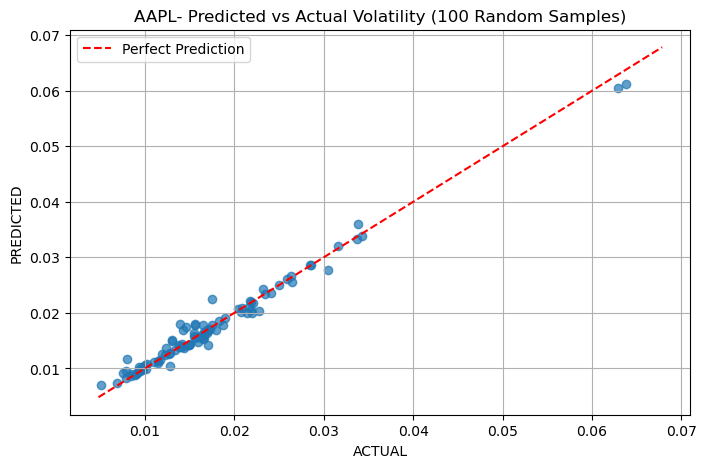

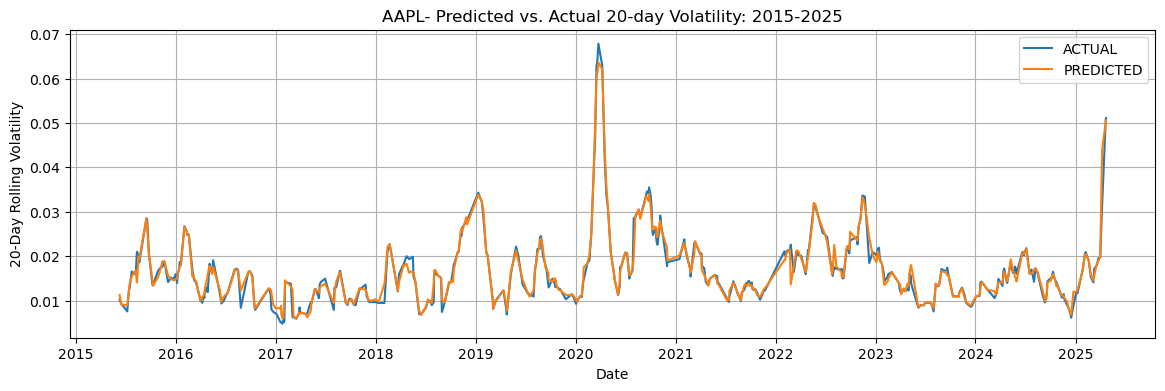


 Predicted 20-Day Volatility for NEXT Trading Day: 0.04759
 Last Known Closing Price: $210.14

📈 Estimated Price Range for Tomorrow:
Upper Bound: $220.14
Lower Bound: $200.14


In [8]:
import datetime as dt
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

end_date = dt.datetime.today().date()
start_date = end_date - dt.timedelta(days=365 * 11) #11 year span

ticker = input("Enter a stock ticker [APPL, TSLA, GOOG, etc.]").upper()
data = yf.download(ticker, start = start_date, end = end_date)
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.dropna(inplace = True)

data['Returns'] = data['Close'].pct_change()
data['MA20'] = data['Close'].rolling(window = 20).mean()
#take the moving/rolling average of past 20 days for short-term trend
data['MA50'] = data['Close'].rolling(window = 50).mean()
#take the moving/rolling average of past 50 days for medium-term trend
data['MA100'] = data['Close'].rolling(window = 100).mean()
#take the moving/rolling average of past 100 days for long-term trend
data['Volatility'] = data['Returns'].rolling(window = 20).std()
#take the moving standard deviation of the past 20 days (this is volatility)
data.dropna(inplace=True)

clean_start_date = pd.to_datetime(end_date - dt.timedelta(days = 365 * 10)) #cut 11th year off as moving averages can't be calculated for it
data = data[data.index >= clean_start_date]

x = data[['MA20', 'MA50', 'MA100']]
y = data['Volatility']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
#splits data into a split: 20% for testing and 80% for training our model

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state = 42)
model.fit(x_train, y_train) #find relationship between x and y
preds = model.predict(x_test) #predict y(volatility) based on x's(moving averages) testing values
print("\n📈 Results for" , ticker, ":")

from sklearn.metrics import mean_absolute_error, r2_score
print("MAE:", round(mean_absolute_error(y_test, preds), 5))
print("R²:", round(r2_score(y_test, preds), 5))

#SCATTERPLOT
plt.figure(figsize=(8, 5))
plt.scatter(y_test.values[:100], preds[:100], alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel("ACTUAL")
plt.ylabel("PREDICTED")
plt.title(ticker + "- Predicted vs Actual Volatility (100 Random Samples)")
plt.legend()
plt.grid(True)
plt.show()

#LINEGRAPH
sorted_dates = y_test.sort_index().index
y_test_sorted = y_test.loc[sorted_dates]
preds_sorted = pd.Series(preds, index=x_test.index).loc[sorted_dates]

plt.figure(figsize=(14, 4))
plt.plot(y_test_sorted.index, y_test_sorted.values, label='ACTUAL')
plt.plot(y_test_sorted.index, preds_sorted.values, label='PREDICTED')
plt.legend()
plt.title(ticker + "- Predicted vs. Actual 20-day Volatility: 2015-2025")
plt.xlabel("Date")
plt.ylabel("20-Day Rolling Volatility")
plt.grid(True)
plt.show()

#PREDICT NEXT DAY
latest_ma20 = data['MA20'].iloc[-1]
latest_ma50 = data['MA50'].iloc[-1]
latest_ma100 = data['MA100'].iloc[-1]

latest_features = pd.DataFrame([[latest_ma20, latest_ma50, latest_ma100]], columns=['MA20', 'MA50', 'MA100'])

next_day_volatility = model.predict(latest_features.values)[0]

last_close = float(data['Close'].iloc[-1].iloc[0])

print(f"\n Predicted 20-Day Volatility for NEXT Trading Day: {round(next_day_volatility, 5)}")
print(f" Last Known Closing Price: ${round(last_close, 2)}")

upper_bound = last_close * (1 + next_day_volatility)
lower_bound = last_close * (1 - next_day_volatility)

print(f"\n📈 Estimated Price Range for Tomorrow:")
print(f"Upper Bound: ${round(upper_bound, 2)}")
print(f"Lower Bound: ${round(lower_bound, 2)}")


## uses datetime to determine current time period. imports yfinance to upload one-year's data of stocks.

Open->	  Price when the market opened that day
High->	  Highest price during the day
Low->     Price during the day
Close->	  Price when the market closed
Volume->  How many shares were traded that day